# Train LSTM

## Import libraries

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import optuna
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import shap
import pickle

## Import data

In [22]:
turn3d = pd.read_csv('/Users/suhrudp/Library/CloudStorage/OneDrive-Personal/Stats/REMAP Open Dataset PD/Analysis/merged_turn_3d_data.csv')

In [23]:
turn3d = turn3d.dropna(subset=['number_of_turning_steps'])
turn3d = turn3d.dropna(subset=['turning_angle'])
turn3d = turn3d.dropna(subset=['type_of_turn'])
turn3d = turn3d.dropna(subset=['turning_duration'])
turn3d = turn3d.dropna(subset=['PD_or_C'])
turn3d = turn3d[turn3d['DBS_state'] != "On DBS"]

In [24]:
turn3d.columns

Index(['Ticks', 'Turn ID', 'Participant ID number', 'PD_or_C',
       'number_of_turning_steps', 'turning_angle', 'type_of_turn',
       'turning_duration', 'On_or_Off_medication', 'DBS_state',
       'clinical_assessment', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7',
       'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'y0', 'y1',
       'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10', 'y11', 'y12',
       'y13', 'y14', 'y15', 'y16', 'z0', 'z1', 'z2', 'z3', 'z4', 'z5', 'z6',
       'z7', 'z8', 'z9', 'z10', 'z11', 'z12', 'z13', 'z14', 'z15', 'z16'],
      dtype='object')

In [25]:
turning_angle_mapping = dict(enumerate(turn3d['turning_angle'].astype('category').cat.categories))
print("turning_angle mapping:")
for code, category in turning_angle_mapping.items():
    print(f"{category}: {code}")

type_of_turn_mapping = dict(enumerate(turn3d['type_of_turn'].astype('category').cat.categories))
print("\ntype_of_turn mapping:")
for code, category in type_of_turn_mapping.items():
    print(f"{category}: {code}")

turning_angle mapping:
135_degrees: 0
180_degrees: 1
225_degrees: 2
270_degrees: 3
360_degrees: 4
90_degrees: 5

type_of_turn mapping:
-: 0
pivot_turn: 1
step_turn: 2


## Preprocess the data

In [26]:
features = [f'x{i}' for i in range(0, 17)] + [f'y{i}' for i in range(0, 17)] + [f'z{i}' for i in range(0, 17)] + ['turning_duration'] + ['number_of_turning_steps'] + ['turning_angle'] + ['type_of_turn']

turn3d.sort_values(['Participant ID number', 'Ticks'], inplace=True)

turn3d['turning_angle'] = turn3d['turning_angle'].astype('category').cat.codes
turn3d['type_of_turn'] = turn3d['type_of_turn'].astype('category').cat.codes

scaler = RobustScaler()
turn3d[features] = scaler.fit_transform(turn3d[features])

turn3d['PD_or_C'] = turn3d['PD_or_C'].astype('category').cat.codes

ovs = SMOTE(random_state=73)
X = turn3d[features + ['Participant ID number']].values
y = turn3d['PD_or_C'].values
X_adasyn, y_adasyn = ovs.fit_resample(X, y)

turn2d_adasyn = pd.DataFrame(X_adasyn, columns=features + ['Participant ID number'])
turn2d_adasyn['PD_or_C'] = y_adasyn

train_data, temp_data = train_test_split(turn2d_adasyn, test_size=0.25, random_state=73, stratify=turn2d_adasyn['PD_or_C'])
val_data, test_data = train_test_split(temp_data, test_size=0.4, random_state=73, stratify=temp_data['PD_or_C'])

print(f'Train data: {len(train_data)} samples')
print(f'Validation data: {len(val_data)} samples')
print(f'Test data: {len(test_data)} samples')

Train data: 80338 samples
Validation data: 16068 samples
Test data: 10712 samples


In [27]:
#scaler_filename = 'scaler_turn3d.pkl'
#with open(scaler_filename, 'wb') as file:
#    pickle.dump(scaler, file)
#print(f'Scaler saved as {scaler_filename}')

## Create a dataset class for sequences

In [28]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, sequence_length=30):
        self.seq_length = sequence_length
        self.data = dataframe
        self.features = features
        self.patient_ids = dataframe['Participant ID number'].values

    def __len__(self):
        return len(self.data) // self.seq_length

    def __getitem__(self, index):
        start_idx = index * self.seq_length
        end_idx = start_idx + self.seq_length
        sequences = self.data.iloc[start_idx:end_idx][self.features].values
        label = self.data.iloc[start_idx:end_idx]['PD_or_C'].values[-1]
        patient_id = self.patient_ids[start_idx]
        return torch.tensor(sequences, dtype=torch.float32), torch.tensor(label, dtype=torch.long), torch.tensor(patient_id, dtype=torch.long)

train_dataset = SequenceDataset(train_data, sequence_length=15)
val_dataset = SequenceDataset(val_data, sequence_length=15)
test_dataset = SequenceDataset(test_data, sequence_length=15)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

## Define the LSTM model

In [29]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_patients, output_dim=2, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.patient_embedding = nn.Embedding(num_patients, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, patient_ids):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        
        patient_intercepts = self.patient_embedding(patient_ids)
        out = out + patient_intercepts
        
        out = self.fc(out)
        return out

## Model training and evaluation

In [30]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f'Using device: {device}')
num_patients = len(turn3d['Participant ID number'].unique())
model = LSTMClassifier(input_dim=len(features), hidden_dim=100, num_patients=num_patients, output_dim=2, num_layers=1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, criterion, optimizer, train_loader, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for sequences, labels, patient_ids in train_loader:
            sequences, labels, patient_ids = sequences.to(device), labels.to(device), patient_ids.to(device)
            optimizer.zero_grad()
            outputs = model(sequences, patient_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}')

def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for sequences, labels, patient_ids in test_loader:
            sequences, labels, patient_ids = sequences.to(device), labels.to(device), patient_ids.to(device)
            outputs = model(sequences, patient_ids)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy: {100 * correct / total:.2f}%')

train_model(model, criterion, optimizer, train_loader, num_epochs=10)

evaluate_model(model, test_loader)

Using device: mps
Epoch 1/10, Loss: 0.6139
Epoch 2/10, Loss: 0.5609
Epoch 3/10, Loss: 0.5347
Epoch 4/10, Loss: 0.5062
Epoch 5/10, Loss: 0.4761
Epoch 6/10, Loss: 0.4347
Epoch 7/10, Loss: 0.3766
Epoch 8/10, Loss: 0.3123
Epoch 9/10, Loss: 0.2300
Epoch 10/10, Loss: 0.1556
Accuracy: 68.63%


## Tune hyperparameters

In [11]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f'Using device: {device}')

num_patients = len(turn3d['Participant ID number'].unique())

def objective(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 50, 200)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    model = LSTMClassifier(input_dim=len(features), hidden_dim=hidden_dim, num_patients=num_patients, output_dim=2, num_layers=num_layers).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model.train()
    for epoch in range(10):
        for sequences, labels, patient_ids in train_loader:
            sequences, labels, patient_ids = sequences.to(device), labels.to(device), patient_ids.to(device)
            optimizer.zero_grad()
            outputs = model(sequences, patient_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for sequences, labels, patient_ids in val_loader:
            sequences, labels, patient_ids = sequences.to(device), labels.to(device), patient_ids.to(device)
            outputs = model(sequences, patient_ids)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total

    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-08-17 11:11:53,292] A new study created in memory with name: no-name-2b95493e-8de0-4a08-97e2-2a3da1dd933c


Using device: mps


[I 2024-08-17 11:12:22,508] Trial 0 finished with value: 0.6993464052287581 and parameters: {'hidden_dim': 174, 'num_layers': 3, 'lr': 0.0013547853290003388, 'batch_size': 16}. Best is trial 0 with value: 0.6993464052287581.
[I 2024-08-17 11:12:39,885] Trial 1 finished with value: 0.7198879551820728 and parameters: {'hidden_dim': 95, 'num_layers': 3, 'lr': 0.0015715893369153096, 'batch_size': 32}. Best is trial 1 with value: 0.7198879551820728.
[I 2024-08-17 11:13:06,553] Trial 2 finished with value: 0.7198879551820728 and parameters: {'hidden_dim': 76, 'num_layers': 3, 'lr': 0.0003309910661708674, 'batch_size': 16}. Best is trial 1 with value: 0.7198879551820728.
[I 2024-08-17 11:13:19,461] Trial 3 finished with value: 0.7273576097105509 and parameters: {'hidden_dim': 51, 'num_layers': 1, 'lr': 0.0014178941911769777, 'batch_size': 32}. Best is trial 3 with value: 0.7273576097105509.
[I 2024-08-17 11:13:29,067] Trial 4 finished with value: 0.6984126984126984 and parameters: {'hidden_di

Best trial:
  Value: 0.7441643323996265
  Params: 
    hidden_dim: 114
    num_layers: 2
    lr: 0.0005316771155433685
    batch_size: 64


## Train model on new hyperparameters

In [12]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

num_patients = len(turn3d['Participant ID number'].unique())

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f'Using device: {device}')

model = LSTMClassifier(input_dim=len(features), hidden_dim=114, num_patients=num_patients, output_dim=2, num_layers=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00053)

def train_model(model, criterion, optimizer, train_loader, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for sequences, labels, patient_ids in train_loader:
            sequences, labels, patient_ids = sequences.to(device), labels.to(device), patient_ids.to(device)
            optimizer.zero_grad()
            outputs = model(sequences, patient_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}')

def evaluate_model(model, val_loader):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for sequences, labels, patient_ids in val_loader:
            sequences, labels, patient_ids = sequences.to(device), labels.to(device), patient_ids.to(device)
            outputs = model(sequences, patient_ids)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, zero_division=0)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    tn, fp, fn, tp = confusion_matrix(all_labels, all_predictions).ravel()
    
    specificity = tn / (tn + fp)
    npv = tn / (tn + fn) if (tn + fn) != 0 else 0

    print(f'Confusion Matrix:\nTN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}')
    print(f'Accuracy: {accuracy:.3f}')
    print(f'Precision (PPV): {precision:.3f}')
    print(f'Negative Predictive Value (NPV): {npv:.3f}')
    print(f'Recall (Sensitivity): {recall:.3f}')
    print(f'Specificity: {specificity:.3f}')
    print(f'F1 Score: {f1:.3f}')

train_model(model, criterion, optimizer, train_loader, num_epochs=20)
evaluate_model(model, val_loader)

Using device: mps
Epoch 1/20, Loss: 0.6761
Epoch 2/20, Loss: 0.5993
Epoch 3/20, Loss: 0.5714
Epoch 4/20, Loss: 0.5486
Epoch 5/20, Loss: 0.5321
Epoch 6/20, Loss: 0.5109
Epoch 7/20, Loss: 0.4978
Epoch 8/20, Loss: 0.4843
Epoch 9/20, Loss: 0.4543
Epoch 10/20, Loss: 0.4304
Epoch 11/20, Loss: 0.4045
Epoch 12/20, Loss: 0.3687
Epoch 13/20, Loss: 0.3367
Epoch 14/20, Loss: 0.2990
Epoch 15/20, Loss: 0.2524
Epoch 16/20, Loss: 0.2118
Epoch 17/20, Loss: 0.1734
Epoch 18/20, Loss: 0.1354
Epoch 19/20, Loss: 0.0939
Epoch 20/20, Loss: 0.0632
Confusion Matrix:
TN: 382, FP: 160, FN: 146, TP: 383
Accuracy: 0.714
Precision (PPV): 0.705
Negative Predictive Value (NPV): 0.723
Recall (Sensitivity): 0.724
Specificity: 0.705
F1 Score: 0.715


In [17]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_patients = len(turn3d['Participant ID number'].unique())

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f'Using device: {device}')

model = LSTMClassifier(input_dim=len(features), hidden_dim=114, num_patients=num_patients, output_dim=2, num_layers=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00053)

def train_model(model, criterion, optimizer, train_loader, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for sequences, labels, patient_ids in train_loader:
            sequences, labels, patient_ids = sequences.to(device), labels.to(device), patient_ids.to(device)
            optimizer.zero_grad()
            outputs = model(sequences, patient_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}')

def evaluate_model(model, test_loader):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for sequences, labels, patient_ids in test_loader:
            sequences, labels, patient_ids = sequences.to(device), labels.to(device), patient_ids.to(device)
            outputs = model(sequences, patient_ids)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, zero_division=0)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    tn, fp, fn, tp = confusion_matrix(all_labels, all_predictions).ravel()
    
    specificity = tn / (tn + fp)
    npv = tn / (tn + fn) if (tn + fn) != 0 else 0

    print(f'Confusion Matrix:\nTN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}')
    print(f'Accuracy: {accuracy:.3f}')
    print(f'Precision (PPV): {precision:.3f}')
    print(f'Negative Predictive Value (NPV): {npv:.3f}')
    print(f'Recall (Sensitivity): {recall:.3f}')
    print(f'Specificity: {specificity:.3f}')
    print(f'F1 Score: {f1:.3f}')

train_model(model, criterion, optimizer, train_loader, num_epochs=20)
evaluate_model(model, test_loader)

Using device: mps
Epoch 1/20, Loss: 0.6435
Epoch 2/20, Loss: 0.5769
Epoch 3/20, Loss: 0.5470
Epoch 4/20, Loss: 0.5243
Epoch 5/20, Loss: 0.4980
Epoch 6/20, Loss: 0.4702
Epoch 7/20, Loss: 0.4363
Epoch 8/20, Loss: 0.3856
Epoch 9/20, Loss: 0.3410
Epoch 10/20, Loss: 0.2820
Epoch 11/20, Loss: 0.2248
Epoch 12/20, Loss: 0.1615
Epoch 13/20, Loss: 0.1040
Epoch 14/20, Loss: 0.0667
Epoch 15/20, Loss: 0.0383
Epoch 16/20, Loss: 0.0300
Epoch 17/20, Loss: 0.0246
Epoch 18/20, Loss: 0.0089
Epoch 19/20, Loss: 0.0023
Epoch 20/20, Loss: 0.0010
Confusion Matrix:
TN: 276, FP: 97, FN: 103, TP: 238
Accuracy: 0.720
Precision (PPV): 0.710
Negative Predictive Value (NPV): 0.728
Recall (Sensitivity): 0.698
Specificity: 0.740
F1 Score: 0.704


In [18]:
def bootstrap_sample(model, test_loader, indices):
    boot_predictions = []
    boot_labels = []
    
    for i in indices:
        sequences, labels, patient_ids = test_loader.dataset[i]
        
        sequences = sequences.unsqueeze(0).to(device)
        labels = torch.tensor([labels]).to(device)
        patient_ids = torch.tensor([patient_ids]).to(device)

        outputs = model(sequences, patient_ids)
        _, predicted = torch.max(outputs.data, 1)
        boot_predictions.extend(predicted.cpu().numpy())
        boot_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(boot_labels, boot_predictions)
    precision = precision_score(boot_labels, boot_predictions, zero_division=0)
    recall = recall_score(boot_labels, boot_predictions)
    f1 = f1_score(boot_labels, boot_predictions)
    tn, fp, fn, tp = confusion_matrix(boot_labels, boot_predictions).ravel()
    
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    npv = tn / (tn + fn) if (tn + fn) != 0 else 0

    return accuracy, precision, recall, f1, specificity, npv

def bootstrap_metrics_parallel_joblib(model, test_loader, n_bootstraps=2000, n_jobs=-1):
    dataset_size = len(test_loader.dataset)
    
    results = Parallel(n_jobs=n_jobs)(delayed(bootstrap_sample)(model, test_loader, np.random.randint(0, dataset_size, dataset_size)) for _ in range(n_bootstraps))

    all_metrics = {
        "accuracy": [result[0] for result in results],
        "precision": [result[1] for result in results],
        "recall": [result[2] for result in results],
        "f1": [result[3] for result in results],
        "specificity": [result[4] for result in results],
        "npv": [result[5] for result in results],
    }
    
    mean_metrics = {metric: np.mean(values) for metric, values in all_metrics.items()}
    std_error_metrics = {metric: np.std(values) for metric, values in all_metrics.items()}

    ci_metrics = {
        metric: (
            np.percentile(values, 2.5),
            np.percentile(values, 97.5)
        )
        for metric, values in all_metrics.items()
    }

    return mean_metrics, std_error_metrics, ci_metrics

def evaluate_model_with_parallel_ci_joblib(model, test_loader, n_bootstraps=2000, n_jobs=-1):
    model.eval()

    mean_metrics, std_error_metrics, ci_metrics = bootstrap_metrics_parallel_joblib(model, test_loader, n_bootstraps, n_jobs)

    print(f'Mean Accuracy: {mean_metrics["accuracy"]:.3f} (SE: {std_error_metrics["accuracy"]:.3f}, 95% CI: {ci_metrics["accuracy"][0]:.3f}-{ci_metrics["accuracy"][1]:.3f})')
    print(f'Mean Precision (PPV): {mean_metrics["precision"]:.3f} (SE: {std_error_metrics["precision"]:.3f}, 95% CI: {ci_metrics["precision"][0]:.3f}-{ci_metrics["precision"][1]:.3f})')
    print(f'Mean Recall (Sensitivity): {mean_metrics["recall"]:.3f} (SE: {std_error_metrics["recall"]:.3f}, 95% CI: {ci_metrics["recall"][0]:.3f}-{ci_metrics["recall"][1]:.3f})')
    print(f'Mean F1 Score: {mean_metrics["f1"]:.3f} (SE: {std_error_metrics["f1"]:.3f}, 95% CI: {ci_metrics["f1"][0]:.3f}-{ci_metrics["f1"][1]:.3f})')
    print(f'Mean Specificity: {mean_metrics["specificity"]:.3f} (SE: {std_error_metrics["specificity"]:.3f}, 95% CI: {ci_metrics["specificity"][0]:.3f}-{ci_metrics["specificity"][1]:.3f})')
    print(f'Mean Negative Predictive Value (NPV): {mean_metrics["npv"]:.3f} (SE: {std_error_metrics["npv"]:.3f}, 95% CI: {ci_metrics["npv"][0]:-.3f}-{ci_metrics["npv"][1]:.3f})')

evaluate_model_with_parallel_ci_joblib(model, test_loader, n_bootstraps=2000, n_jobs=-1)

/Users/suhrudp/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mean Accuracy: 0.720 (SE: 0.016, 95% CI: 0.686-0.752)
Mean Precision (PPV): 0.710 (SE: 0.025, 95% CI: 0.662-0.756)
Mean Recall (Sensitivity): 0.697 (SE: 0.024, 95% CI: 0.651-0.746)
Mean F1 Score: 0.703 (SE: 0.019, 95% CI: 0.664-0.739)
Mean Specificity: 0.740 (SE: 0.023, 95% CI: 0.694-0.784)
Mean Negative Predictive Value (NPV): 0.728 (SE: 0.023, 95% CI: 0.681-0.771)


In [26]:
def evaluate_model_with_roc(model, test_loader):
    model.eval()
    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for sequences, labels, patient_ids in test_loader:
            sequences, labels, patient_ids = sequences.to(device), labels.to(device), patient_ids.to(device)
            outputs = model(sequences, patient_ids)
            probabilities = torch.softmax(outputs, dim=1)[:, 1]
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, zero_division=0)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    tn, fp, fn, tp = confusion_matrix(all_labels, all_predictions).ravel()
    
    specificity = tn / (tn + fp)
    npv = tn / (tn + fn) if (tn + fn) != 0 else 0

    print(f'Confusion Matrix:\nTN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}')
    print(f'Accuracy: {accuracy:.3f}')
    print(f'Precision (PPV): {precision:.3f}')
    print(f'Negative Predictive Value (NPV): {npv:.3f}')
    print(f'Recall (Sensitivity): {recall:.3f}')
    print(f'Specificity: {specificity:.3f}')
    print(f'F1 Score: {f1:.3f}')

    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    plt.style.use('ggplot')
    plt.figure(figsize=(12, 12))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve for 3D Turning Data')
    plt.legend(loc='lower right')

    plt.savefig("roc_curve_turn3d.png", dpi=600)
    plt.close()

train_model(model, criterion, optimizer, train_loader, num_epochs=20)
evaluate_model_with_roc(model, test_loader)

Epoch 1/20, Loss: 0.0000
Epoch 2/20, Loss: 0.0000
Epoch 3/20, Loss: 0.0000
Epoch 4/20, Loss: 0.0000
Epoch 5/20, Loss: 0.0000
Epoch 6/20, Loss: 0.0000
Epoch 7/20, Loss: 0.0000
Epoch 8/20, Loss: 0.0000
Epoch 9/20, Loss: 0.0000
Epoch 10/20, Loss: 0.0000
Epoch 11/20, Loss: 0.0000
Epoch 12/20, Loss: 0.0000
Epoch 13/20, Loss: 0.0000
Epoch 14/20, Loss: 0.0000
Epoch 15/20, Loss: 0.0000
Epoch 16/20, Loss: 0.0000
Epoch 17/20, Loss: 0.0000
Epoch 18/20, Loss: 0.0000
Epoch 19/20, Loss: 0.0000
Epoch 20/20, Loss: 0.0000
Confusion Matrix:
TN: 272, FP: 101, FN: 108, TP: 233
Accuracy: 0.707
Precision (PPV): 0.698
Negative Predictive Value (NPV): 0.716
Recall (Sensitivity): 0.683
Specificity: 0.729
F1 Score: 0.690


In [22]:
#model_filename = 'model_turn3d.pth'
#torch.save(model.state_dict(), model_filename)
#print(f'Model saved as {model_filename}')

Model saved as model_turn3d.pth


## Using SHAP to explain model predictions

In [23]:
background = train_data.sample(100)[features].values 

def model_predict(inputs):
    inputs = torch.tensor(inputs, dtype=torch.float32).to(device) 
    model.eval()
    with torch.no_grad():
        sequences = inputs.view(inputs.shape[0], -1, len(features))
        patient_ids = torch.zeros(inputs.shape[0], dtype=torch.int64).to(device)
        outputs = model(sequences, patient_ids)
        probabilities = nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy()
explainer = shap.KernelExplainer(model_predict, background)

test_sample = test_data.sample(10)[features].values

shap_values = explainer.shap_values(test_sample)

shap.initjs()

# for class 1
shap.force_plot(explainer.expected_value[1], shap_values[0][:, 1], test_sample[0], feature_names=features)

  0%|          | 0/10 [00:00<?, ?it/s]

In [24]:
background = train_data.sample(100)[features].values 

def model_predict(inputs):
    inputs = torch.tensor(inputs, dtype=torch.float32).to(device) 
    model.eval()
    with torch.no_grad():
        sequences = inputs.view(inputs.shape[0], -1, len(features))
        patient_ids = torch.zeros(inputs.shape[0], dtype=torch.int64).to(device)
        outputs = model(sequences, patient_ids)
        probabilities = nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy()
explainer = shap.KernelExplainer(model_predict, background)

explainer = shap.KernelExplainer(model_predict, background)

test_sample = test_data.sample(10)[features].values

shap_values = explainer.shap_values(test_sample)

shap.initjs()

# for class 0
shap.force_plot(explainer.expected_value[0], shap_values[0][:, 0], test_sample[0], feature_names=features)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

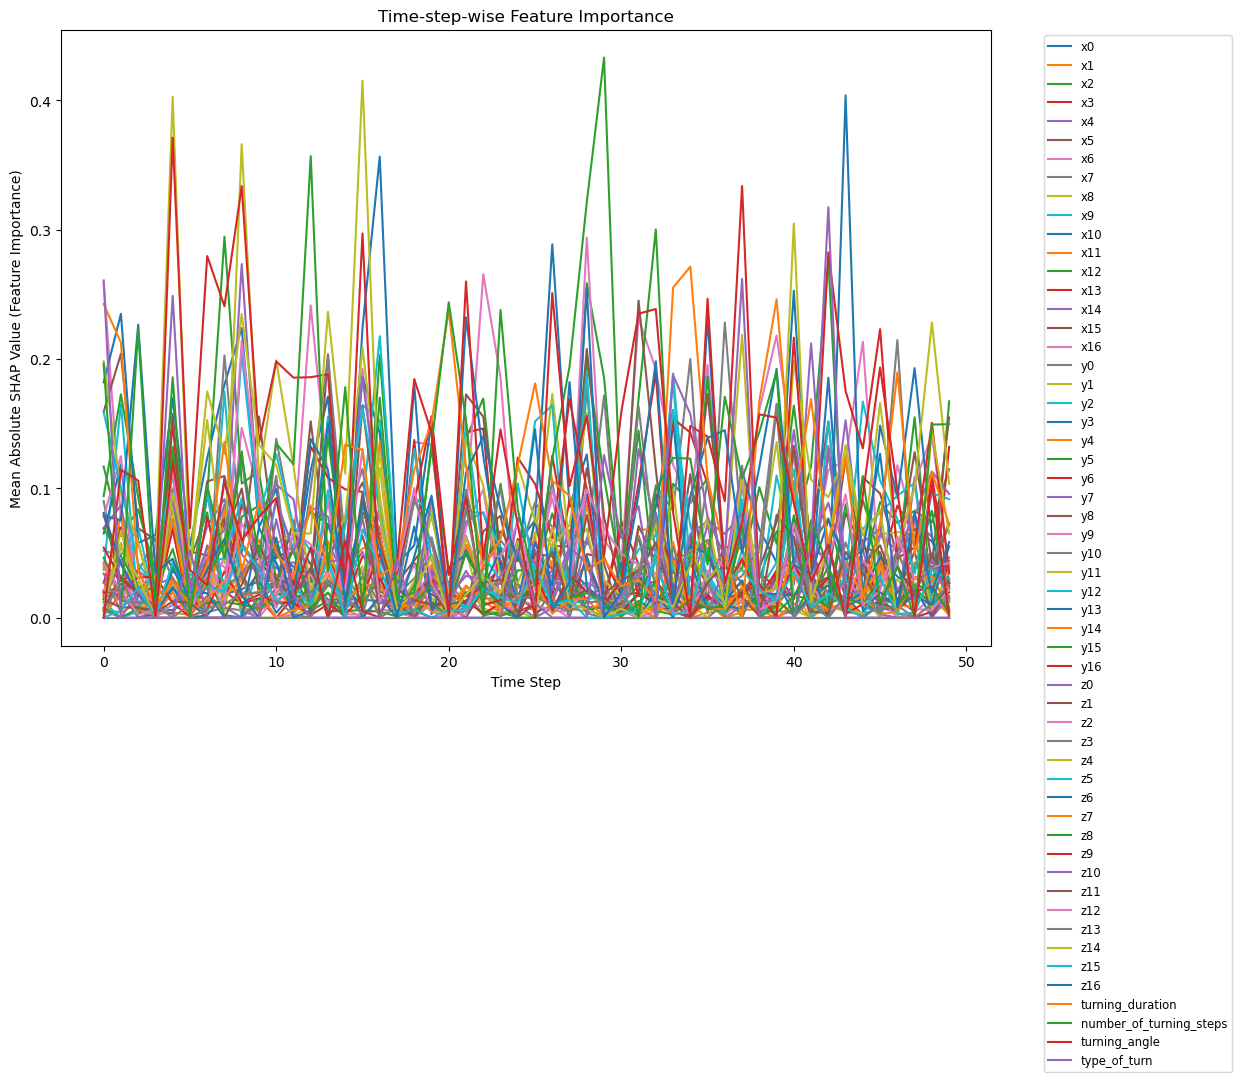

In [25]:
def model_predict(inputs):
    inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
    inputs = inputs.unsqueeze(1)
    model.eval()
    with torch.no_grad():
        patient_ids = torch.zeros(inputs.shape[0], dtype=torch.int64).to(device)
        outputs = model(inputs, patient_ids)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy()

shap_sample = train_data.sample(100, random_state=73)
shap_sample_features = shap_sample[features].values.reshape(-1, 50, len(features))

num_sequences = 10
num_time_steps = 50
test_sample = test_data.sample(num_sequences * num_time_steps, random_state=73)[features].values
test_sample = test_sample.reshape(num_sequences, num_time_steps, len(features))

shap_values_all_time_steps = np.zeros((test_sample.shape[1], test_sample.shape[2]))

for t in range(test_sample.shape[1]):
    test_sample_timestep = test_sample[:, t, :]
    shap_sample_timestep = shap_sample_features[:, t, :]

    explainer = shap.KernelExplainer(model_predict, shap_sample_timestep)

    shap_values_timestep = explainer.shap_values(test_sample_timestep)
    
    shap_values_mean = np.mean(np.abs(shap_values_timestep[0]), axis=1)
    
    shap_values_all_time_steps[t, :] = shap_values_mean

plt.figure(figsize=(12, 8))
for i, feature_name in enumerate(features):
    plt.plot(range(test_sample.shape[1]), shap_values_all_time_steps[:, i], label=feature_name)

plt.xlabel('Time Step')
plt.ylabel('Mean Absolute SHAP Value (Feature Importance)')
plt.title('Time-step-wise Feature Importance')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.show()

In [27]:
def model_predict(inputs):
    inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
    inputs = inputs.unsqueeze(1)
    model.eval()
    with torch.no_grad():
        patient_ids = torch.zeros(inputs.shape[0], dtype=torch.int64).to(device)
        outputs = model(inputs, patient_ids)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy()

shap_sample = train_data.sample(500, random_state=73)
shap_sample_features = shap_sample[features].values.reshape(-1, 500, len(features))

num_sequences = 10
num_time_steps = 500
test_sample = test_data.sample(num_sequences * num_time_steps, random_state=73)[features].values
test_sample = test_sample.reshape(num_sequences, num_time_steps, len(features))

shap_values_all_time_steps = np.zeros((test_sample.shape[1], test_sample.shape[2]))

for t in range(test_sample.shape[1]):
    test_sample_timestep = test_sample[:, t, :]
    shap_sample_timestep = shap_sample_features[:, t, :]

    explainer = shap.KernelExplainer(model_predict, shap_sample_timestep)

    shap_values_timestep = explainer.shap_values(test_sample_timestep)
    
    shap_values_mean = np.mean(np.abs(shap_values_timestep[0]), axis=1)
    
    shap_values_all_time_steps[t, :] = shap_values_mean

plt.style.use('ggplot')

plt.figure(figsize=(40, 8))
for i, feature_name in enumerate(features):
    plt.plot(range(test_sample.shape[1]), shap_values_all_time_steps[:, i], label=feature_name)

plt.xticks(ticks=np.arange(0, num_time_steps + 1, step=15))

plt.xlabel('Time Step')
plt.ylabel('Mean Absolute SHAP Value (Feature Importance)')
plt.title('Time-step-wise Feature Importance')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.savefig("shap_feature_importance_turn3d.png", dpi=600, bbox_inches='tight')
plt.close()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/suhrudp/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
/Users/suhrudp/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/suhrudp/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
/Users/suhrudp/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/suhrudp/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
/Users/suhrudp/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

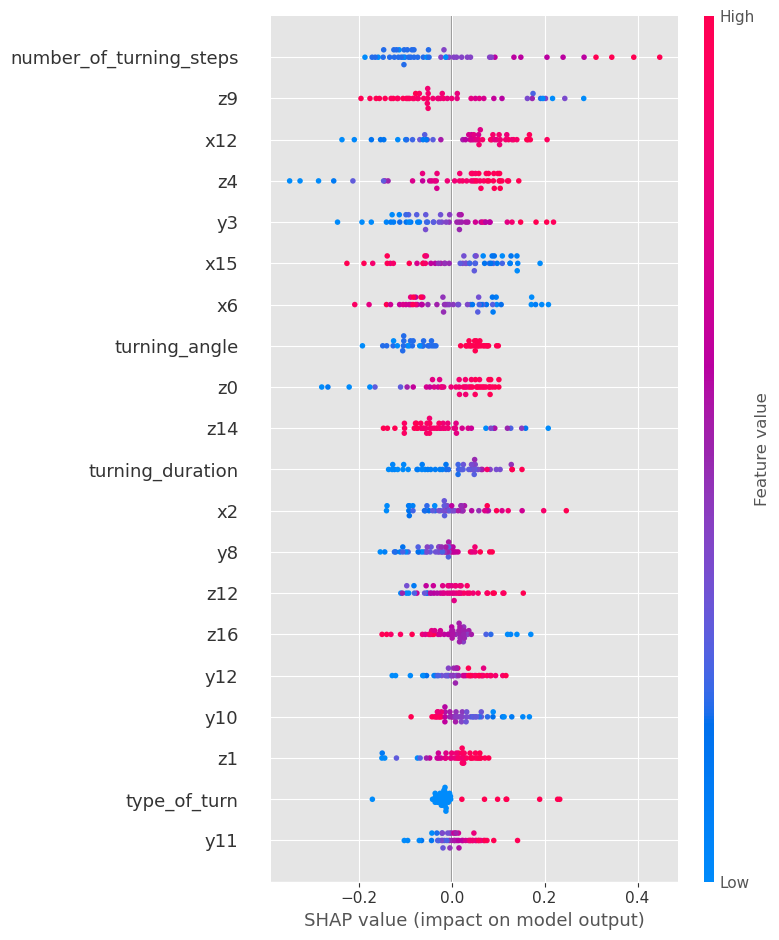

In [28]:
def model_predict(inputs):
    inputs = torch.tensor(inputs, dtype=torch.float32).to(device) 
    model.eval()
    with torch.no_grad():
        sequences = inputs.view(inputs.shape[0], -1, len(features))
        patient_ids = torch.zeros(inputs.shape[0], dtype=torch.int64).to(device)
        outputs = model(sequences, patient_ids)
        probabilities = nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy()

shap_sample = train_data.sample(50, random_state=73)
shap_sample_features = shap_sample[features].values

explainer = shap.KernelExplainer(model_predict, background)
shap_values = explainer.shap_values(shap_sample_features)

shap_values_class_1 = shap_values[:, :, 1]

shap.summary_plot(shap_values_class_1, shap_sample_features, feature_names=features)

In [29]:
plt.style.use('ggplot')

shap_sample = train_data.sample(1000, random_state=73)
shap_sample_features = shap_sample[features].values

explainer = shap.KernelExplainer(model_predict, background)
shap_values = explainer.shap_values(shap_sample_features)

shap_values_class_1 = shap_values[:, :, 1]

plt.figure()

shap.summary_plot(shap_values_class_1, shap_sample_features, feature_names=features, show=False)

plt.savefig("shap_summary_plot_turn3d.png", bbox_inches='tight', dpi=600)

plt.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

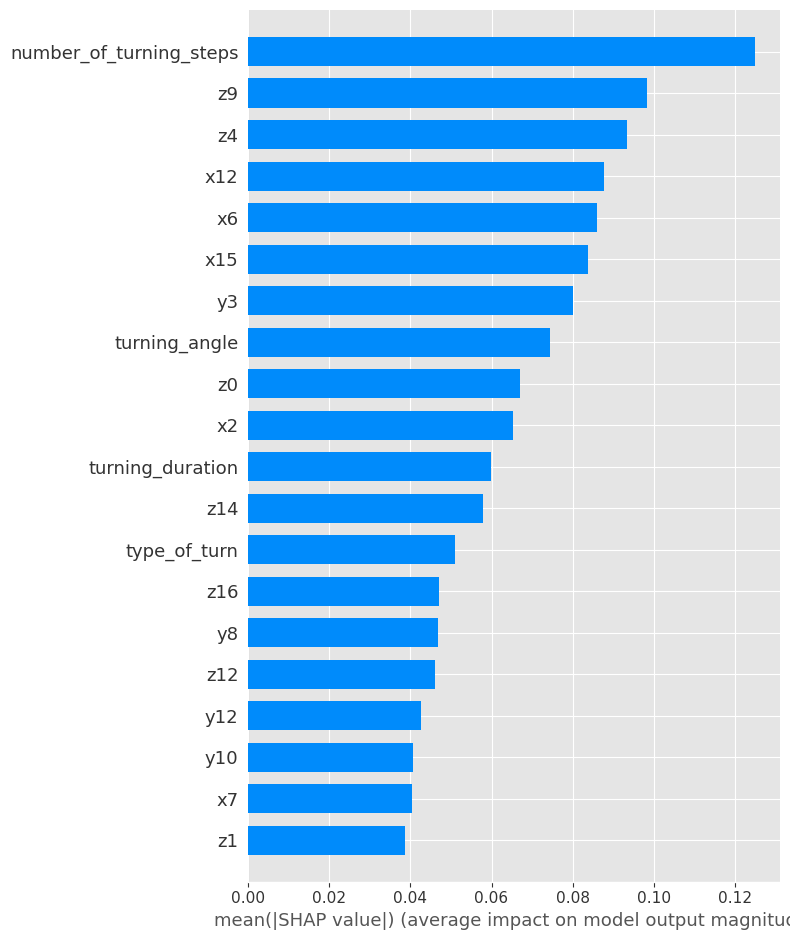

In [30]:
shap_sample = train_data.sample(50, random_state=73)
shap_sample_features = shap_sample[features].values

def model_predict(inputs):
    inputs = torch.tensor(inputs, dtype=torch.float32).to(device) 
    model.eval()
    with torch.no_grad():
        sequences = inputs.view(inputs.shape[0], -1, len(features))
        patient_ids = torch.zeros(inputs.shape[0], dtype=torch.int64).to(device)
        outputs = model(sequences, patient_ids)
        probabilities = nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy()

background = train_data.sample(100)[features].values
explainer = shap.KernelExplainer(model_predict, background)

shap_values = explainer.shap_values(shap_sample_features)

shap_values_class_1 = shap_values[:, :, 1]

shap_values_abs_class_1 = np.abs(shap_values_class_1)

shap.summary_plot(shap_values_abs_class_1, shap_sample_features, feature_names=features, plot_type="bar")

In [31]:
plt.style.use('ggplot')

shap_sample = train_data.sample(1000, random_state=73)
shap_sample_features = shap_sample[features].values

def model_predict(inputs):
    inputs = torch.tensor(inputs, dtype=torch.float32).to(device) 
    model.eval()
    with torch.no_grad():
        sequences = inputs.view(inputs.shape[0], -1, len(features))
        patient_ids = torch.zeros(inputs.shape[0], dtype=torch.int64).to(device)
        outputs = model(sequences, patient_ids)
        probabilities = nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy()

background = train_data.sample(100)[features].values
explainer = shap.KernelExplainer(model_predict, background)

shap_values = explainer.shap_values(shap_sample_features)

shap_values_class_1 = shap_values[:, :, 1]

shap_values_abs_class_1 = np.abs(shap_values_class_1)

plt.figure()

shap.summary_plot(shap_values_abs_class_1, shap_sample_features, feature_names=features, plot_type="bar", show=False)

plt.savefig("shap_summary_bar_plot_turn3d.png", bbox_inches='tight', dpi=600)

plt.close()

  0%|          | 0/1000 [00:00<?, ?it/s]